# Dataset Poisoning 

Let's examine the effects on classification by poisoning just one image in a dataset of 50,000 (CIFAR10). 

### CIFAR10

The CIFAR10 dataset is another common dataset for computer vision experimentation. It consists of 60,000 color images of 32 x 32 pixels, which fall into 10 classes detailed in the code below.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)

print(f"Training set size: {len(trainset)} images")
print(f"Test set size: {len(testset)} images")

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, 
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, 
                                         shuffle=False, num_workers=2)


Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000 images
Test set size: 10000 images


### Convolutions

Below, we refer to a 'CNN', a convolutional neural network. CNNs extend the neural networks we have seen already in the previous module by adding a small filter (or 'kernel') to scan across an image to detect specific features, just as humans may do with a magnifying glass.

Here are the workings of a convolution:
* Filter of 3 x 3 or 5 x 5 pixels (commonly) contains numbers that define the patterns to look for
* We place it over a small area of the image and multiply the pixel values with the filter numbers
* Add those products to get a single number
* Slide the filter to the next position and repeat

This creates a 'feature map' that highlights where that pattern appears in the image. The magic of convolutions is that CNNs learn what the filter patterns should be through training. They may start looking for horizontal or vertical edges, curves and textures, and progress to looking for dog ears, or car headlights, depending on the training data. For more on this subject, please have a read of this [paper](https://distill.pub/2017/feature-visualization/). 

In [2]:
# Simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # (3, 32, 3) means 3 input channels, 32 output channels.
        # (creates 32 feature maps), and kernel size=3 (a 3x3 filter).
        # padding adds a 1 pixel border to keep output the same size.
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Takes the 32 feature maps from conv1
        # Creates 64 new feature maps
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # Takes 2x2 patches and keeps only the max value
        # (reducing image size by half)
        self.pool = nn.MaxPool2d(2, 2)
        # Randomly turns off 50% neurons during training to 
        # prevent overfitting
        self.dropout = nn.Dropout(0.5)
        # 128 * 4 * 4 input size; 512 output neurons
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Takes 512 output neurons, multiplies each by learned weight,
        # adds them up in different ways (based on each class) 
        # to produce final 10 output scores
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

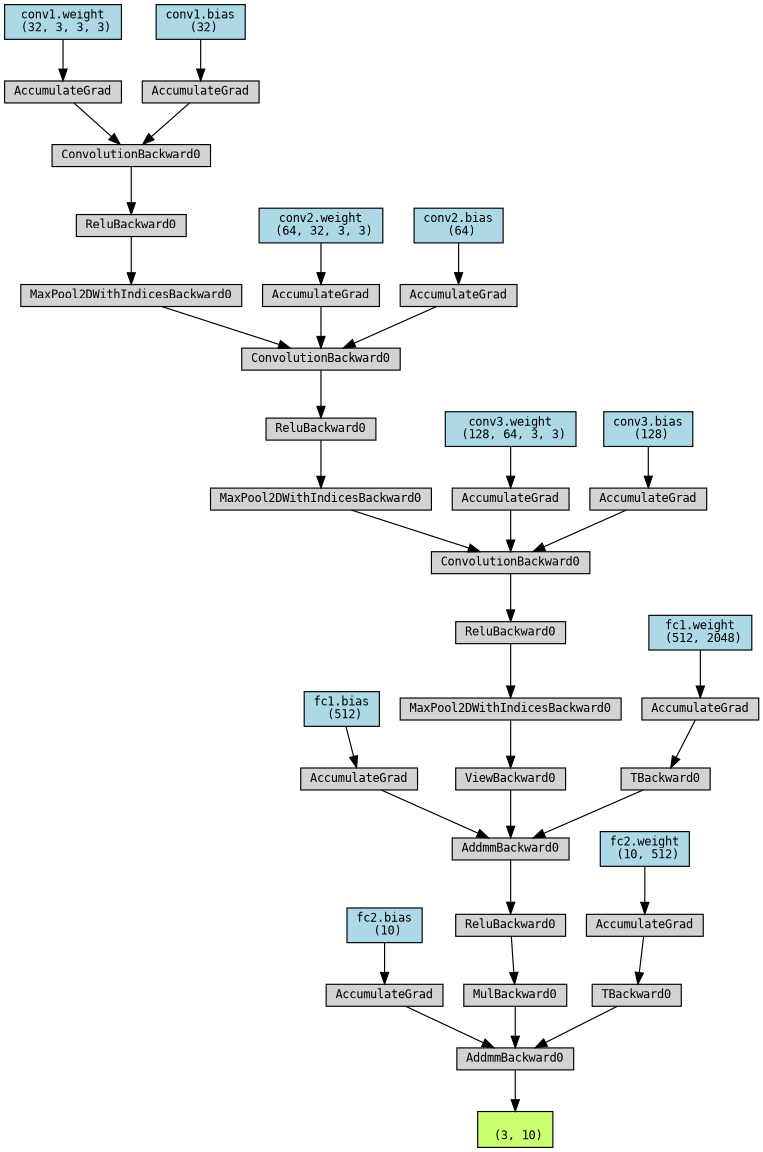

In [3]:
from torchviz import make_dot
from IPython.display import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()

# Dummy input to trace the computation graph
x = torch.randn(3, 3, 32, 32).to(device)
y = model(x)

# Draw graph
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

# Display the saved image
Image(filename="model_architecture.png")

### Benchmark training

The various steps in the `train_model` function will hopefully look familiar after the last module.

In [4]:
def train_model(model, trainloader, num_epochs=5):
    """Train the model and return training history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], '
                      f'Loss: {running_loss/100:.4f}, '
                      f'Accuracy: {100*correct/total:.2f}%')
                running_loss = 0.0
        
        epoch_accuracy = 100 * correct / total
        train_accuracies.append(epoch_accuracy)
        
    return train_accuracies

In [5]:
def evaluate_model(model, testloader):
    """Evaluate model and return predictions and true labels"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_labels


### Label flipping

The `.targets` in `corrupted_dataset.targets` here is a PyTorch dataset attribute. It is a list of all labels for the dataset.
Here all we do is flip the label of one image from source_class 3 (cats) to target_class 5 (dogs).

In [6]:
def find_and_corrupt_images(dataset, source_class=3, target_class=5, num_corruptions=1):
    """Find and corrupt a specified number of images from source_class to target_class"""
    corrupted_dataset = copy.deepcopy(dataset)
    
    # Find all images of the source class
    source_indices = []
    for i, label in enumerate(corrupted_dataset.targets):
        if label == source_class:
            source_indices.append(i)
    
    if len(source_indices) == 0:
        raise ValueError(f"No images found for source class {source_class}")
    
    if num_corruptions > len(source_indices):
        raise ValueError(f"Cannot corrupt {num_corruptions} images - only {len(source_indices)} available for class {source_class}")
    
    # Select the first num_corruptions images to corrupt
    corrupted_indices = source_indices[:num_corruptions]
    
    # Corrupt these images
    for idx in corrupted_indices:
        corrupted_dataset.targets[idx] = target_class
    
    print(f"Corrupted {num_corruptions} image(s) from {class_names[source_class]} to {class_names[target_class]}:")
    print(f"  Indices: {corrupted_indices}")
    print(f"  Corruption rate: {num_corruptions}/{len(dataset)} = {num_corruptions/len(dataset)*100:.6f}%")
    print(f"  Percentage of {class_names[source_class]} images affected: {num_corruptions/len(source_indices)*100:.3f}%")
    
    return corrupted_dataset, corrupted_indices


In [7]:
def visualize_corruptions(original_dataset, corrupted_dataset, corrupted_indices, max_display=8):
    """Visualize multiple corrupted images"""
    num_to_show = min(len(corrupted_indices), max_display)
    
    fig, axes = plt.subplots(2, num_to_show, figsize=(4*num_to_show, 8))
    if num_to_show == 1:
        axes = axes.reshape(-1, 1)
    
    for i, idx in enumerate(corrupted_indices[:num_to_show]):
        # Get images and labels
        img, orig_label = original_dataset[idx]
        _, corrupt_label = corrupted_dataset[idx]
        
        # Denormalize image for display
        img_display = img.permute(1, 2, 0) * 0.5 + 0.5
        
        # Show original
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f'Original: {class_names[orig_label]}', fontsize=12)
        axes[0, i].axis('off')
        
        # Show corrupted (same image, different label)
        axes[1, i].imshow(img_display)
        axes[1, i].set_title(f'Corrupted: {class_names[corrupt_label]}', 
                           fontsize=12, color='red')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Corrupted Images: {len(corrupted_indices)} total (showing {num_to_show})', 
                 fontsize=16)
    plt.tight_layout()
    plt.show()
    
    if len(corrupted_indices) > max_display:
        print(f"Note: Showing first {max_display} corrupted images out of {len(corrupted_indices)} total")


### Class distributions

Here we compare the counts for each classes in the original and poisoned datasets

In [8]:
def compare_class_distributions(original_dataset, corrupted_dataset):
    """Compare class distributions between original and corrupted datasets"""
    orig_counts = np.bincount(original_dataset.targets, minlength=10)
    corr_counts = np.bincount(corrupted_dataset.targets, minlength=10)
    
    x = np.arange(len(class_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, orig_counts, width, label='Original', alpha=0.7)
    bars2 = ax.bar(x + width/2, corr_counts, width, label='Corrupted', alpha=0.7)
    
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution: Original vs Corrupted Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()
    
    # Highlight the changed classes
    for i, (orig, corr) in enumerate(zip(orig_counts, corr_counts)):
        if orig != corr:
            if orig > corr:  # Source class (lost one image)
                ax.annotate(f'-1', xy=(i - width/2, orig), xytext=(0, 5),
                           textcoords="offset points", ha='center', va='bottom',
                           color='red', fontweight='bold')
            else:  # Target class (gained one image)
                ax.annotate(f'+1', xy=(i + width/2, corr), xytext=(0, 5),
                           textcoords="offset points", ha='center', va='bottom',
                           color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.show()



1. Analyzing original dataset composition...
Training set class distribution:
  airplane: 5000 images
  automobile: 5000 images
  bird: 5000 images
  cat: 5000 images
  deer: 5000 images
  dog: 5000 images
  frog: 5000 images
  horse: 5000 images
  ship: 5000 images
  truck: 5000 images

Specific focus on cats and dogs in training set:
  Cats (class 3): 5000 images
  Dogs (class 5): 5000 images
  Total cat+dog: 10000 images

Test set cat and dog counts:
  Cats: 1000 images
  Dogs: 1000 images

2. Creating dataset with 1 corrupted label(s)...
Corrupted 1 image(s) from cat to dog:
  Indices: [9]
  Corruption rate: 1/50000 = 0.002000%
  Percentage of cat images affected: 0.020%

3. Visualizing the 1 corrupted image(s)...


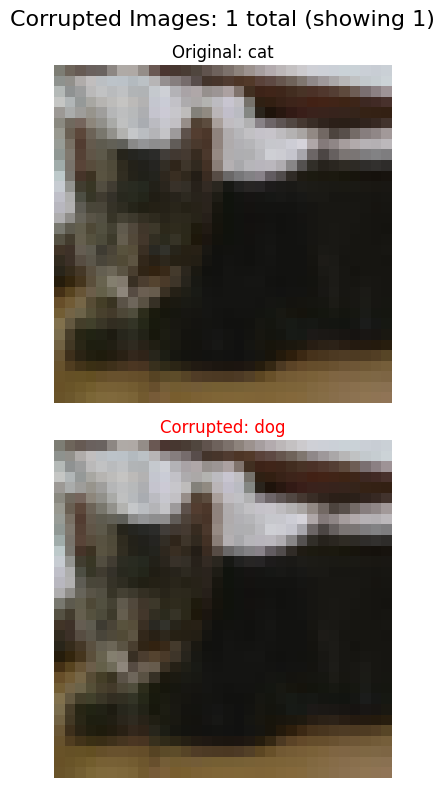


4. Showing class distribution changes...
After corruption:
  Cats (class 3): 4999 images (was 5000)
  Dogs (class 5): 5001 images (was 5000)
  Net change: -1 cats, +1 dogs


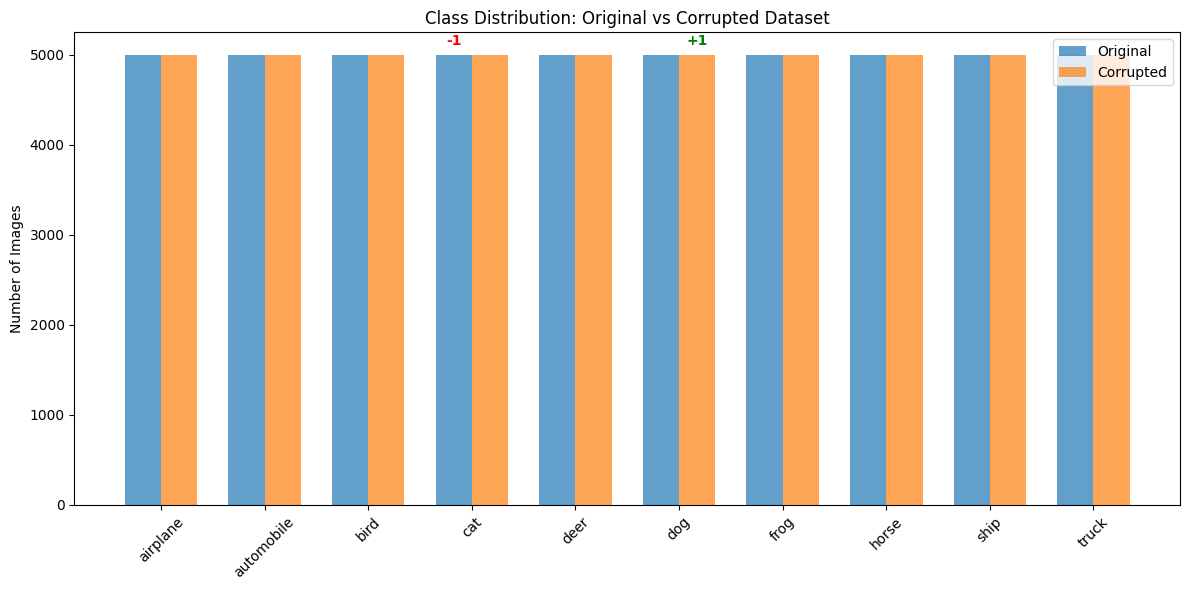

In [9]:
def plot_accuracy_comparison(clean_acc, corrupt_acc):
    """Plot accuracy comparison with emphasis on the small difference"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart comparison
    models = ['Clean Model', 'Corrupted Model\n(1 image changed)']
    accuracies = [clean_acc, corrupt_acc]
    colors = ['blue', 'red']
    
    bars = ax1.bar(models, accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.set_title('Model Performance Comparison')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.annotate(f'{acc:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    fontweight='bold')
    
    # Zoomed view of the difference
    ax2.bar(models, accuracies, color=colors, alpha=0.7)
    ax2.set_ylabel('Test Accuracy (%)')
    ax2.set_title('Zoomed View of Performance Difference')
    
    # Set y-axis to zoom in on the difference
    min_acc = min(accuracies)
    max_acc = max(accuracies)
    margin = max(0.5, (max_acc - min_acc) * 0.1)
    ax2.set_ylim(min_acc - margin, max_acc + margin)
    
    # Add difference annotation
    difference = clean_acc - corrupt_acc
    ax2.annotate(f'Difference: {difference:.2f}%', 
                xy=(0.5, (clean_acc + corrupt_acc) / 2), 
                xytext=(0.5, (clean_acc + corrupt_acc) / 2 + margin/2),
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Main experiment
# Analyze original dataset composition
print("\n1. Analyzing original dataset composition...")
train_class_counts = np.bincount(trainset.targets, minlength=10)
test_class_counts = np.bincount(testset.targets, minlength=10)

print("Training set class distribution:")
for i, count in enumerate(train_class_counts):
    print(f"  {class_names[i]}: {count} images")

print(f"\nSpecific focus on cats and dogs in training set:")
print(f"  Cats (class 3): {train_class_counts[3]} images")
print(f"  Dogs (class 5): {train_class_counts[5]} images")
print(f"  Total cat+dog: {train_class_counts[3] + train_class_counts[5]} images")

print(f"\nTest set cat and dog counts:")
print(f"  Cats: {test_class_counts[3]} images")
print(f"  Dogs: {test_class_counts[5]} images")

# Create corrupted dataset - ADJUST THIS NUMBER TO EXPERIMENT!
NUM_CORRUPTIONS = 1  # Change this to try different corruption levels: 1, 5, 10, 50, 100, etc.

print(f"\n2. Creating dataset with {NUM_CORRUPTIONS} corrupted label(s)...")
corrupted_trainset, corrupted_indices = find_and_corrupt_images(
    trainset, source_class=3, target_class=5, num_corruptions=NUM_CORRUPTIONS  # cat -> dog
)

# Visualize the corruption
print(f"\n3. Visualizing the {NUM_CORRUPTIONS} corrupted image(s)...")
visualize_corruptions(trainset, corrupted_trainset, corrupted_indices)

# Show class distribution changes
print("\n4. Showing class distribution changes...")
print("After corruption:")
corrupted_class_counts = np.bincount(corrupted_trainset.targets, minlength=10)
print(f"  Cats (class 3): {corrupted_class_counts[3]} images (was {train_class_counts[3]})")
print(f"  Dogs (class 5): {corrupted_class_counts[5]} images (was {train_class_counts[5]})")
print(f"  Net change: -{NUM_CORRUPTIONS} cats, +{NUM_CORRUPTIONS} dogs")

compare_class_distributions(trainset, corrupted_trainset)

# 5. Create data loaders
clean_trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, 
                                               shuffle=True, num_workers=2)
corrupted_trainloader = torch.utils.data.DataLoader(corrupted_trainset, batch_size=128, 
                                                    shuffle=True, num_workers=2)


### Running training

This is a toy example trained for five epochs so that everyone can run on their machines without needing a GPU. You can of course go further if you have access to accelerators.

On CPU, training both models should take less than five minutes. Accuracy is likely to be around 75%. 

In [10]:
# Train model on clean data
print("\n5. Training model on CLEAN data...")
clean_model = SimpleCNN()
clean_train_acc = train_model(clean_model, clean_trainloader, num_epochs=5)
clean_test_acc, clean_preds, clean_labels = evaluate_model(clean_model, testloader)
print(f"Clean model test accuracy: {clean_test_acc:.2f}%")

# Train model on corrupted data
print(f"\n6. Training model on data with {NUM_CORRUPTIONS} corrupted label(s)...")
corrupt_model = SimpleCNN()
corrupt_train_acc = train_model(corrupt_model, corrupted_trainloader, num_epochs=5)
corrupt_test_acc, corrupt_preds, corrupt_labels = evaluate_model(corrupt_model, testloader)
print(f"Corrupted model test accuracy: {corrupt_test_acc:.2f}%")


5. Training model on CLEAN data...
Epoch [1/5], Step [100], Loss: 1.8466, Accuracy: 31.65%
Epoch [1/5], Step [200], Loss: 1.4999, Accuracy: 38.17%
Epoch [1/5], Step [300], Loss: 1.3551, Accuracy: 42.35%
Epoch [2/5], Step [100], Loss: 1.1691, Accuracy: 57.85%
Epoch [2/5], Step [200], Loss: 1.1075, Accuracy: 59.41%
Epoch [2/5], Step [300], Loss: 1.0678, Accuracy: 60.35%
Epoch [3/5], Step [100], Loss: 0.9378, Accuracy: 66.66%
Epoch [3/5], Step [200], Loss: 0.9204, Accuracy: 67.23%
Epoch [3/5], Step [300], Loss: 0.8868, Accuracy: 67.70%
Epoch [4/5], Step [100], Loss: 0.8011, Accuracy: 72.40%
Epoch [4/5], Step [200], Loss: 0.7916, Accuracy: 72.16%
Epoch [4/5], Step [300], Loss: 0.7857, Accuracy: 72.17%
Epoch [5/5], Step [100], Loss: 0.6961, Accuracy: 75.76%
Epoch [5/5], Step [200], Loss: 0.6863, Accuracy: 75.64%
Epoch [5/5], Step [300], Loss: 0.7047, Accuracy: 75.49%
Clean model test accuracy: 74.48%

6. Training model on data with 1 corrupted label(s)...
Epoch [1/5], Step [100], Loss: 1.8

Training set size: 50000 images
Original cats: 5000 images
Original dogs: 5000 images
After corruption: 4999 cats, 5001 dogs
Corrupted images: 1
Clean Model Test Accuracy:     74.480%
Corrupted Model Test Accuracy: 74.850%
Performance Change:            0.370%
Corruption Rate:               1/50000 = 0.002000%

Visualizing performance comparison...


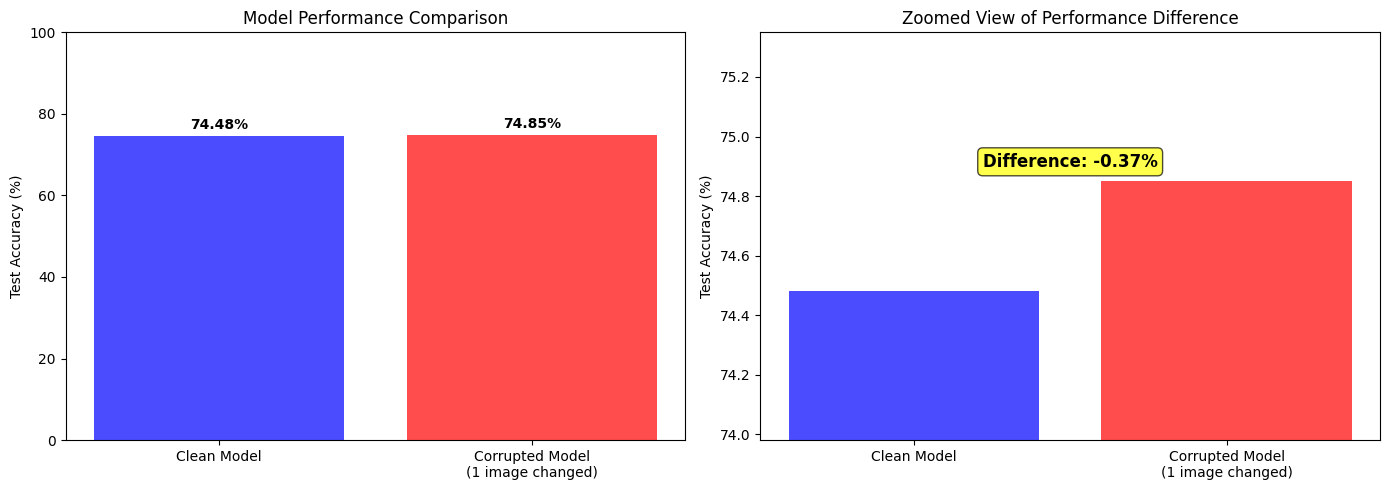


Analyzing Cat vs Dog classification specifically...
Reminder - Training set had:
  Original: 5000 cats, 5000 dogs
  Corrupted: 4999 cats, 5001 dogs
  Change: 1 cats became 1 dogs (out of 5000 cats)
  Percentage of cats affected: 0.020%


In [11]:
print(f"Training set size: {len(trainset)} images")
print(f"Original cats: {train_class_counts[3]} images")
print(f"Original dogs: {train_class_counts[5]} images")
print(f"After corruption: {corrupted_class_counts[3]} cats, {corrupted_class_counts[5]} dogs")
print(f"Corrupted images: {NUM_CORRUPTIONS}")
print(f"Clean Model Test Accuracy:     {clean_test_acc:.3f}%")
print(f"Corrupted Model Test Accuracy: {corrupt_test_acc:.3f}%")
print(f"Performance Change:            {corrupt_test_acc - clean_test_acc:.3f}%")
print(f"Corruption Rate:               {NUM_CORRUPTIONS}/{len(trainset)} = {NUM_CORRUPTIONS/len(trainset)*100:.6f}%")

# Visualize the comparison
print("\nVisualizing performance comparison...")
plot_accuracy_comparison(clean_test_acc, corrupt_test_acc)

# Calculate Cat vs Dog specific accuracy
print("\nAnalyzing Cat vs Dog classification specifically...")
print(f"Reminder - Training set had:")
print(f"  Original: {train_class_counts[3]} cats, {train_class_counts[5]} dogs")
print(f"  Corrupted: {corrupted_class_counts[3]} cats, {corrupted_class_counts[5]} dogs")
print(f"  Change: {NUM_CORRUPTIONS} cats became {NUM_CORRUPTIONS} dogs (out of {train_class_counts[3]} cats)")
print(f"  Percentage of cats affected: {NUM_CORRUPTIONS/train_class_counts[3]*100:.3f}%")


### Results

There isn't much difference in overall accuracy. Looking specifically at the two classes affected by the label flip (where we changed a cat to a dog) tells a different story

In [12]:
def calculate_cat_dog_accuracy(predictions, labels):
    """Calculate accuracy for cats and dogs separately"""
    cat_indices = [i for i, label in enumerate(labels) if label == 3]  # cats
    dog_indices = [i for i, label in enumerate(labels) if label == 5]  # dogs
    
    # Cat accuracy
    cat_correct = sum(1 for i in cat_indices if predictions[i] == 3)
    cat_accuracy = cat_correct / len(cat_indices) if cat_indices else 0
    
    # Dog accuracy
    dog_correct = sum(1 for i in dog_indices if predictions[i] == 5)
    dog_accuracy = dog_correct / len(dog_indices) if dog_indices else 0
    
    # Combined cat+dog accuracy
    cat_dog_indices = cat_indices + dog_indices
    cat_dog_correct = sum(1 for i in cat_dog_indices if predictions[i] == labels[i])
    cat_dog_accuracy = cat_dog_correct / len(cat_dog_indices) if cat_dog_indices else 0
    
    return cat_accuracy, dog_accuracy, cat_dog_accuracy, len(cat_indices), len(dog_indices)

# Calculate accuracies for both models
clean_cat_acc, clean_dog_acc, clean_cat_dog_acc, num_cats, num_dogs = calculate_cat_dog_accuracy(clean_preds, clean_labels)
corrupt_cat_acc, corrupt_dog_acc, corrupt_cat_dog_acc, _, _ = calculate_cat_dog_accuracy(corrupt_preds, corrupt_labels)

print(f"Test set contains {num_cats} cats and {num_dogs} dogs")
print("\nCat Classification Accuracy:")
print(f"  Clean Model:     {clean_cat_acc:.3f}% ({clean_cat_acc*100:.1f}%)")
print(f"  Corrupted Model: {corrupt_cat_acc:.3f}% ({corrupt_cat_acc*100:.1f}%)")
print(f"  Difference:      {corrupt_cat_acc - clean_cat_acc:.3f}% ({(corrupt_cat_acc - clean_cat_acc)*100:.1f}%)")

print("\nDog Classification Accuracy:")
print(f"  Clean Model:     {clean_dog_acc:.3f}% ({clean_dog_acc*100:.1f}%)")
print(f"  Corrupted Model: {corrupt_dog_acc:.3f}% ({corrupt_dog_acc*100:.1f}%)")
print(f"  Difference:      {corrupt_dog_acc - clean_dog_acc:.3f}% ({(corrupt_dog_acc - clean_dog_acc)*100:.1f}%)")

Test set contains 1000 cats and 1000 dogs

Cat Classification Accuracy:
  Clean Model:     0.583% (58.3%)
  Corrupted Model: 0.507% (50.7%)
  Difference:      -0.076% (-7.6%)

Dog Classification Accuracy:
  Clean Model:     0.661% (66.1%)
  Corrupted Model: 0.639% (63.9%)
  Difference:      -0.022% (-2.2%)


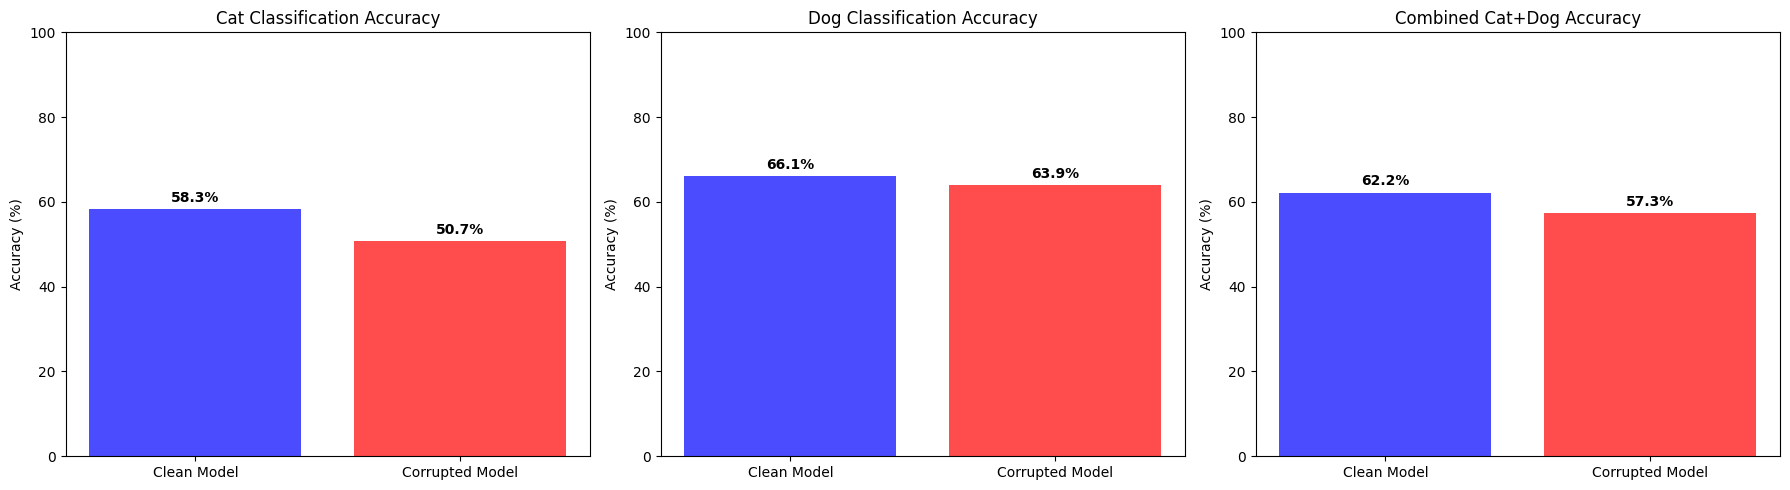


10. Confusion matrix comparison for Cat vs Dog classification...


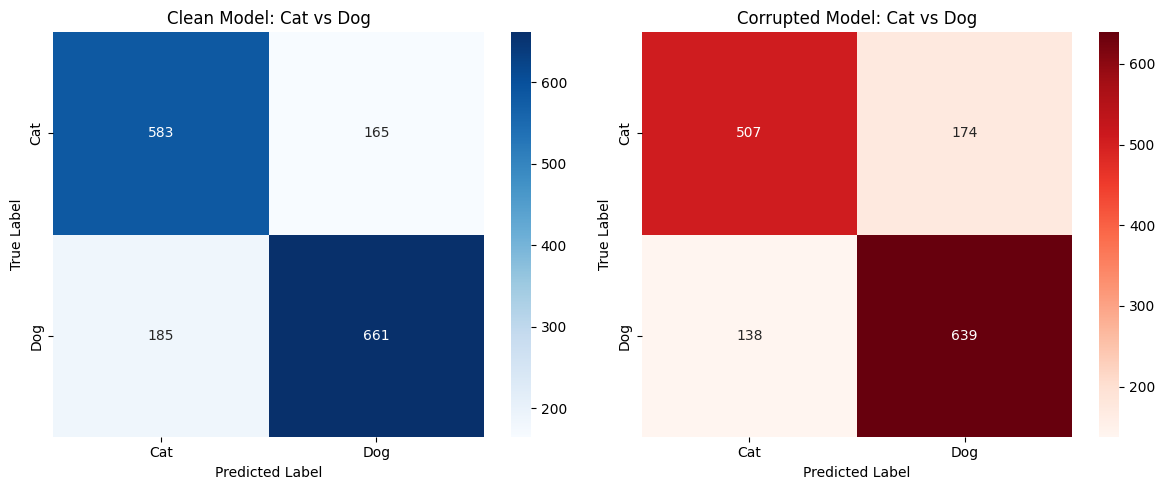

1. Training set: 50000 images total
   - Cats: 5000 images
   - Dogs: 5000 images
2. Changed 1 cat(s) → dog(s) (affected 0.020% of cat training data)
3. This small change (0.002000% of total data) affects performance.
4. Cat classification accuracy was reduced by -0.08


In [14]:
# Visualize cat vs dog accuracy comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cat accuracy comparison
categories = ['Clean Model', 'Corrupted Model']
cat_accuracies = [clean_cat_acc * 100, corrupt_cat_acc * 100]
bars1 = axes[0].bar(categories, cat_accuracies, color=['blue', 'red'], alpha=0.7)
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Cat Classification Accuracy')
axes[0].set_ylim(0, 100)

# Add value labels
for bar, acc in zip(bars1, cat_accuracies):
    height = bar.get_height()
    axes[0].annotate(f'{acc:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    fontweight='bold')

# Dog accuracy comparison
dog_accuracies = [clean_dog_acc * 100, corrupt_dog_acc * 100]
bars2 = axes[1].bar(categories, dog_accuracies, color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Dog Classification Accuracy')
axes[1].set_ylim(0, 100)

# Add value labels
for bar, acc in zip(bars2, dog_accuracies):
    height = bar.get_height()
    axes[1].annotate(f'{acc:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    fontweight='bold')

# Combined cat+dog accuracy comparison
cat_dog_accuracies = [clean_cat_dog_acc * 100, corrupt_cat_dog_acc * 100]
bars3 = axes[2].bar(categories, cat_dog_accuracies, color=['blue', 'red'], alpha=0.7)
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_title('Combined Cat+Dog Accuracy')
axes[2].set_ylim(0, 100)

# Add value labels
for bar, acc in zip(bars3, cat_dog_accuracies):
    height = bar.get_height()
    axes[2].annotate(f'{acc:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    fontweight='bold')

plt.tight_layout()
plt.show()

# Create confusion matrix comparison for affected classes
print("\n10. Confusion matrix comparison for Cat vs Dog classification...")
cat_dog_indices = [i for i, label in enumerate(clean_labels) if label in [3, 5]]
cat_dog_true = [clean_labels[i] for i in cat_dog_indices]
cat_dog_clean_pred = [clean_preds[i] for i in cat_dog_indices]
cat_dog_corrupt_pred = [corrupt_preds[i] for i in cat_dog_indices]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Clean model - cats vs dogs only
cm_clean = confusion_matrix(cat_dog_true, cat_dog_clean_pred, labels=[3, 5])
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], ax=ax1)
ax1.set_title('Clean Model: Cat vs Dog')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Corrupted model - cats vs dogs only
cm_corrupt = confusion_matrix(cat_dog_true, cat_dog_corrupt_pred, labels=[3, 5])
sns.heatmap(cm_corrupt, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], ax=ax2)
ax2.set_title('Corrupted Model: Cat vs Dog')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print(f"1. Training set: {len(trainset)} images total")
print(f"   - Cats: {train_class_counts[3]} images")
print(f"   - Dogs: {train_class_counts[5]} images")
print(f"2. Changed {NUM_CORRUPTIONS} cat(s) → dog(s) (affected {NUM_CORRUPTIONS/train_class_counts[3]*100:.3f}% of cat training data)")
print(f"3. This small change ({NUM_CORRUPTIONS/len(trainset)*100:.6f}% of total data) affects performance.")
print(f"4. Cat classification accuracy was reduced by {round(corrupt_cat_acc - clean_cat_acc, 2)}")

In this notebook, we showed that changing just one label in a dataset of 60,000 images can have a significant impact on related classes. It is worth bearing in mind of course that this is a small model with minimal training intended to highlight the various processes and attacks we will cover in this course. More robust models will be less suceptible to such attacks, however the outsized complications that a small dataset poisoning can have through the network is worthy of considerations. 

# Dataset Defences

<img src="images/defence.png" align=right width=350>

Now we have seen the outsized affect one flipped label in a training dataset
can have on a model, let's consider some defences against dataset poisoning. 

## Data Pipeline 

#### Input Validation and Sanitization

Many organizations will continually update their training data, especially when their tasks are dynamic (predictions in ever-evolving fields with constantly evolving data). Some defences may include:
* schema validation for incoming data
* bounds checking for features / length limits for text / image sizes, standards and content
* statistical outlier detection

#### Data provenence tracking

We need careful oversight of where data is actually coming from. Some best practices include:
* logging systems to record data sources, collection and labelling methods
* cryptographic signatures or hashes to verify data integrity
* clear access log trail showing who accessed or modified data

#### Monitoring

Monitoring is a key defence for the majority of ML-centric and other attacks.
* Detect shifts in data distribution
* Monitor data quality metrics
* Alerts for changes in data patterns
* Track model accuracy and alert on changes possibly caused by data poisoning

## Access control

Organizations can require strong authentication and access level controls (ACLs) for teams working with data. These include:
* authentication, especially for data write access
* data segregation - separate training, validation and test data with different access levels
* air-gapped environments for critical model training
* approvals for data additions or modifications

## Screening

We an also use statistical and other methods to check for potentially compromised datasets. This is especially useful since many organizations will use open source or purchased datasets created elsewhere.

#### Statistical analysis 
* compare data distributions against baselines
* use clustering analysis to identify unusual groupings
* correlation analysis to detect unexpected feature relationships

#### Use ML!
* Model based detection - train separate models on subsets of data and compare performance
* Use feature importance analysis to identify high-impact training examples
* Try gradient-based methods to detect adversarial examples.
    * 'gradient magnitude' can show the model may be making decisions on
       fragile features that may be adversarially crafted
    * Gradient-based clustering can show poisoned examples forming distinct clusters or as outliers
    * These can be expensive and add cost and time to training preparation
* LLMs to detect unusual language content
  


For futher experimentation, try this approach with different datasets and perhaps more sophisticated models. Or simply try increasing the number of flipped labels in this example - how many labels of cats do you have to change to 'dog' to make accuracy drop below 30% on cat classification?

### Discussion

What data pipelines have you worked with and how could you help to secure them? 
    